Install requirements:

In [1]:
#!pip install torch
#!pip install numpy
#!pip install tqdm
#!pip install trimesh
#!pip install gdown
#!pip install scipy
#!pip install mesh-to-sdf
#!pip install matplotlib
#!pip install scikit-image

Install tiny-cuda-nn for fast hash grid implementation:

In [2]:
#!git clone --recursive git@github.com:NVlabs/tiny-cuda-nn.git
#!cd tiny-cuda-nn/bindings/torch && python setup.py install

Download dataset:

In [3]:
#!gdown 1R_dUallEeDikQCaeFXthXS4b2XFHJQvc --folder

Folder for train/val/inference data:

In [4]:
#os.mkdir("data")

Now you may need to restart kernel or update terminal.

In [5]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset
import numpy as np
import trimesh
from mesh_to_sdf import sample_sdf_near_surface
import pyrender
import scipy
import os
import tinycudann
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
from skimage.metrics import structural_similarity as ssim

In [6]:
def get_rays_torch(
    scene_info, c2w, coords=None, use_viewdir=True, use_pixel_centers=True
):
    H, W, K = scene_info["H"], scene_info["W"], scene_info["K"]
    pixel_center = 0.5 if use_pixel_centers else 0.0

    if coords is not None:
        j, i = coords[..., 0] + pixel_center, coords[..., 1] + pixel_center
        if len(coords.shape) == 3:
            c2w = c2w[:, None]
    else:
        i, j = torch.meshgrid(
            torch.arange(W, dtype=torch.float32) + pixel_center,
            torch.arange(H, dtype=torch.float32) + pixel_center,
            indexing="xy",
        )

    dirs = torch.stack(
        [
            (i - K[0, 2]) / K[0, 0],
            (j - K[1, 2]) / K[1, 1],
            K[2, 2] * torch.ones_like(i),
        ],
        -1,
    )
    # Rotate ray directions from camera frame to the world frame
    rays_d = torch.sum(dirs[..., None, :] * c2w[..., :3, :3], -1)
    # Translate camera frame's origin to the world frame. It is the origin of all rays.
    rays_o = c2w[..., :3, -1].unsqueeze(-2).expand_as(rays_d)

    if use_viewdir:
        rays_d = rays_d / (torch.norm(rays_d, dim=-1, keepdim=True) + EPS)

    return rays_o, rays_d

In [7]:
class SDF_Dataset(Dataset):
    def __init__(self, batch_size, path):
        super().__init__()

        self.batch_size = batch_size
        data = np.load(path, allow_pickle=True).item()
        self.points, self.distances = data["points"], data["distances"]
        self.centroid, self.scale = data["centroid"], data["scale"]

        self.points = torch.tensor(self.points)
        self.distances = torch.tensor(self.distances)
        self.centroid = torch.tensor(self.centroid)
        self.scale = torch.tensor(self.scale)
    
    def __len__(self):
        return len(self.points)
    
    def __getitem__(self, index):
        return {
            'points': self.points[index],
            'dist': self.distances[index]
        }

    def get_scaling_params(self):
        return self.centroid, self.scale
    
    def n_batches(self):
        return len(self) // self.batch_size

    def get_batch(self, index):
        l = index * self.batch_size
        r = l + self.batch_size
        
        return {
            'points': self.points[l:r],
            'dist': self.distances[l:r]
        }
    
    def cuda(self):
        self.points = self.points.cuda()
        self.distances = self.distances.cuda()
        return self
    
    def shuffle(self):
        ind = torch.randperm(len(self.points))
        self.points = self.points[ind]
        self.distances = self.distances[ind]
        return self

class Cam_Dataset(Dataset):
    def __init__(self, batch_size, path):
        super().__init__()

        self.batch_size = batch_size
        data = np.load(path, allow_pickle=True).item()
        self.points, self.directions, self.intersections, self.normals = data["points"], data["directions"], data["intersections"], data["normals"]

        self.points = torch.tensor(self.points)
        self.directions = torch.tensor(self.directions)
        self.intersections = torch.tensor(self.intersections)
        self.normals = torch.tensor(self.normals)
    
    def __len__(self):
        return len(self.points)
    
    def __getitem__(self, index):
        return {
            'points': self.points[index],
            'direct': self.directions[index],
            'dist': self.intersections[index],
            'norm': self.normals[index]
        }
    
    def n_batches(self):
        return len(self) // self.batch_size

    def get_batch(self, index):
        l = index * self.batch_size
        r = l + self.batch_size
        return {
            'points': self.points[l:r],
            'direct': self.directions[l:r],
            'dist': self.intersections[l:r],
            'norm': self.normals[l:r]
        }
    
    def cuda(self):
        self.points = self.points.cuda()
        self.directions = self.directions.cuda()
        self.intersections = self.intersections.cuda()
        self.normals = self.normals.cuda()
        return self
    
    def shuffle(self):
        ind = torch.randperm(len(self.points))
        self.points = self.points[ind]
        self.directions = self.directions[ind]
        self.intersections = self.intersections[ind]
        self.normals = self.normals[ind]
        return self


In [8]:
def generate_points(path, n):
    mesh = trimesh.load(path)

    points, sdf = sample_sdf_near_surface(mesh, number_of_points=n)
    sdf = sdf.astype(np.float32)[:, np.newaxis]

    print("Mesh centroid", mesh.bounding_box.centroid)
    vertices = mesh.vertices - mesh.bounding_box.centroid
    vert_distances = np.linalg.norm(vertices, axis=1)
    print("Mesh scale", np.max(vert_distances))

    return {
        'points': points.astype(np.float32),
        'distances': sdf.astype(np.float32),
        'centroid': mesh.bounding_box.centroid,
        'scale': np.max(vert_distances)
    }

def run_raytrace(mesh, origins, directions):
    batch_size = 100000
    n = origins.shape[0]
    intersections = np.zeros((n, 3))
    normals = np.zeros((n, 3))

    for i in tqdm(range(0, n, batch_size)):
        cur_batch_size = min(batch_size, n - i)

        batch_intersections, index_ray, index_tri = mesh.ray.intersects_location(
            origins[i:i+cur_batch_size],
            directions[i:i+cur_batch_size],
            multiple_hits=False
        )

        intersections_batch = np.zeros((cur_batch_size, 3))
        intersections_batch[index_ray] = batch_intersections
        intersections[i:i+cur_batch_size] = intersections_batch

        normals_batch = np.zeros((cur_batch_size, 3))
        normals_batch[index_ray] = mesh.face_normals[index_tri]
        normals[i:i+cur_batch_size] = normals_batch

    return intersections.astype(np.float32), normals.astype(np.float32)

def generate_rays_from_camera(path, cam_rot, cam_t):
    resolution = (800, 800)
    fov = 45
    mesh = trimesh.load(path)

    scene = mesh.scene()
    scene.camera.resolution = resolution

    cam_rot = np.array(cam_rot) * np.pi / 180
    cam_t = np.array(cam_t)
    scene.set_camera(
        angles=cam_rot,
        fov=fov * (scene.camera.resolution / scene.camera.resolution.max()),
    )

    origins, directions, pixels = scene.camera_rays()
    origins = origins + cam_t[None, :]
    directions = directions / np.linalg.norm(directions, axis=1, keepdims=True)

    intersections, normals = run_raytrace(mesh, origins, directions)

    return {
        'points': origins.astype(np.float32), 
        'directions': directions.astype(np.float32),
        'intersections': intersections.astype(np.float32),
        'normals': normals.astype(np.float32)
    }

In [9]:
mesh_path = 'lego-bulldozer/lego-856-bulldozer.stl'

Generate dataset (5-10 minutes):

In [10]:
# train
n = 25000000
data = generate_points(mesh_path, n)
np.save('data/train.npy', data)

# val
n = 1000000
data = generate_points(mesh_path, n)
np.save('data/val.npy', data)

Mesh centroid [-2.00003529 -5.20002556 12.36992693]
Mesh scale 36.700242473470425
Mesh centroid [-2.00003529 -5.20002556 12.36992693]
Mesh scale 36.700242473470425


In [11]:
class HashGridEncoder(nn.Module):
    def __init__(
        self,
        range,
        dim=3,
        n_levels=16,
        n_features_per_level=2,
        log2_hashmap_size=15,
        base_resolution=16,
        finest_resolution=512,
    ):
        super().__init__()
        self.input_dim = dim
        b = (finest_resolution / base_resolution) ** (1 / (n_levels - 1))
        config = {
            "otype": "Grid",
            "type": "Hash",
            "n_levels": n_levels,
            "n_features_per_level": n_features_per_level,
            "log2_hashmap_size": log2_hashmap_size,
            "base_resolution": base_resolution,
            "finest_resolution": finest_resolution,
            "per_level_scale": b,
        }
        self.enc = tinycudann.Encoding(self.input_dim, config)
        self.range = range

    def forward(self, x):
        x = (x + self.range) / (2 * self.range)
        orig_shape = x.shape
        x = x.reshape(-1, self.input_dim)
        x = self.enc(x).float()
        x = x.reshape(*orig_shape[:-1], -1)
        return x

class SinEncoder(nn.Module):
    def __init__(self, dim, factor=1):
        super().__init__()
        self.dim = dim
        self.factor = factor
        self.out_dim = 3 * (1 + dim * 2)

    def forward(self, x):
        res = [x]
        for i in range(self.dim):
            res.append(torch.sin((x / self.factor) * 2**i))
            res.append(torch.cos((x / self.factor) * 2**i))
        return torch.cat(res, dim=-1)

In [12]:
class MLPNet(nn.Module):
    def __init__(self, dim, n_layers):
        super().__init__()

        self.net = nn.Sequential(
            nn.LazyLinear(dim),
            nn.ReLU(),
            tinycudann.Network(
                dim,
                dim,
                {
                    "otype": "CutlassMLP",
                    "activation": "ReLU",
                    "output_activation": "None",
                    "n_neurons": dim,
                    "n_hidden_layers": n_layers,
                },
            ),
        )
        self.dist = nn.Sequential(
            nn.Linear(dim, 1)
        )

    def forward(self, x):
        x = self.net(x).float()
        dist = self.dist(x)
        return dist

    def get_loss(self, x, dist):
        dist_pred = self(x)
        loss = F.mse_loss(dist_pred, dist) * 1000
        return loss


class Model(nn.Module):
    def __init__(self, encoder, net, compile=False):
        super().__init__()
        self.encoder = encoder
        self.net = net

    def get_loss(self, x, dist):
        torch.compiler.cudagraph_mark_step_begin()
        if self.encoder:
            x = self.encoder(x)
        return self.net.get_loss(x, dist)

    def forward(self, x):
        torch.compiler.cudagraph_mark_step_begin()
        if self.encoder:
            x = self.encoder(x)
        dist = self.net(x)
        return dist

In [13]:
def calculate_lambert(normal_buffer, intersection_buffer, light_position, intensity=1.0, ambient=0.1):
    mask = np.squeeze(np.linalg.norm(normal_buffer, axis=-1, keepdims=True) > 1e-8)
    light_directions = light_position - intersection_buffer
    light_distances = np.linalg.norm(light_directions, axis=-1, keepdims=True)
    light_directions_normalized = light_directions / (light_distances + 1e-8)

    normal_abs = np.linalg.norm(normal_buffer, axis=-1, keepdims=False)
    normal_abs[~mask] = 1
    normals_normalized = np.zeros_like(normal_buffer)
    normals_normalized[mask] = (normal_buffer / np.expand_dims(normal_abs, axis=-1))[mask]
    
    dot_product = np.sum(normals_normalized * light_directions_normalized, axis=-1)
    lambertian = np.maximum(0, dot_product)

    light_buffer = lambertian * intensity
    light_buffer[mask] =  (light_buffer * (1 - ambient) + ambient)[mask]

    return light_buffer

In [14]:
class MetricLogger:
    def __init__(self, alpha=0.95) -> None:
        self.alpha = alpha
        self.exp = None
        self.metric = 0
        self.metric_list = []

    def update(self, metric) -> None:
        if self.exp is None:
            self.exp = metric
        else:
            self.exp = self.exp * self.alpha + metric * (1 - self.alpha)
        self.metric = metric
        self.metric_list.append(metric)

    def mean(self) -> float:
        return np.mean(self.metric_list)
    
    def ema(self) -> float:
        return self.exp

class Trainer:
    def __init__(self, train_data, val_data, cam_data, tqdm_leave=True):
        
        self.ds_train = train_data.cuda()
        self.ds_val = val_data.cuda()
        self.ds_cam = cam_data.cuda()

        self.centroid, self.scale = self.ds_train.get_scaling_params()
        self.centroid = self.centroid.cuda()
        self.scale = self.scale.cuda()

        self.tqdm_leave = tqdm_leave

    def set_model(self, model):
        self.model = model
        with torch.no_grad():
            model.forward(torch.randn(10, 3, device="cuda"))

        self.optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=1, gamma=0.25)
        self.alpha = 0.99
        self.logger_loss = MetricLogger(self.alpha)
        
        self.n_steps = 0
        self.n_epoch = 0

    def train(self):
        self.ds_train.shuffle()

        bar = tqdm(range(self.ds_train.n_batches()), leave=self.tqdm_leave)
        for batch_idx in bar:
            batch = self.ds_train.get_batch(batch_idx)
            points, dist = batch["points"], batch["dist"]

            loss = self.model.get_loss(points, dist)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            self.logger_loss.update(loss.item())

            bar.set_description(
                f"loss: {self.logger_loss.ema():.6f}"
            )
            
            self.n_steps += 1

        self.n_epoch += 1

        return {
            "train_loss": self.logger_loss.mean()
        }

    @torch.no_grad()
    def val(self):
        val_loss = 0
        bar = tqdm(range(self.ds_val.n_batches()), leave=self.tqdm_leave)
        for batch_idx in bar:
            batch = self.ds_val.get_batch(batch_idx)
            points, dist = batch["points"], batch["dist"]

            loss = self.model.get_loss(points, dist)

            val_loss += loss.item()

            bar.set_description(
                f"val_loss: {val_loss / (batch_idx + 1):.6f}"
            )

        val_loss /= self.ds_val.n_batches()

        self.scheduler.step()

        return {
            "val_loss": val_loss
        }

    def scale_point(self, point):
        return ((point - self.centroid) / self.scale).float()

    @torch.no_grad()
    def render(self):
        img_mask_pred = torch.zeros((800 * 800, 1), device="cuda")
        img_intersec_pred = torch.zeros((800 * 800, 3), device="cuda")
        img_normals_pred = torch.zeros((800 * 800, 3), device="cuda")

        steps_num = 150
        threshold = 1e-1
        
        for batch_idx in tqdm(range(self.ds_cam.n_batches()), leave=self.tqdm_leave):
            batch = self.ds_cam.get_batch(batch_idx)
            points, direct = batch["points"], batch["direct"]
            points = self.scale_point(points.clone())
            initial_points = points.clone()
            batch_size = points.shape[0]

            for step in range(steps_num):
                dist_pred = self.model(points)
                points += dist_pred * direct
            
            last_dist = self.model(points)

            mask = (torch.abs(last_dist) < threshold) * (torch.norm(points, dim=1, keepdim=True) < 1)
            normals = torch.zeros_like(points)
            
            if mask.any():
                delta = 1e-3
                grad = torch.stack([
                    self.model(points + delta * torch.tensor([1, 0, 0], device=points.device)) -
                    self.model(points - delta * torch.tensor([1, 0, 0], device=points.device)),
                    self.model(points + delta * torch.tensor([0, 1, 0], device=points.device)) -
                    self.model(points - delta * torch.tensor([0, 1, 0], device=points.device)),
                    self.model(points + delta * torch.tensor([0, 0, 1], device=points.device)) -
                    self.model(points - delta * torch.tensor([0, 0, 1], device=points.device)),
                ], dim=-1) / (2 * delta)
                normals = grad / torch.norm(grad, dim=-1, keepdim=True)
            
            normals = normals.squeeze()
            
            img_mask_pred[batch_idx * batch_size : (batch_idx + 1) * batch_size] = (
                mask
            )
            img_intersec_pred[batch_idx * batch_size : (batch_idx + 1) * batch_size] = (
                points * self.scale + self.centroid
            )

            img_normals_pred[batch_idx * batch_size: (batch_idx + 1) * batch_size] = normals * mask

        img_mask_pred = img_mask_pred.reshape(800, 800, 1)
        img_intersec_pred = img_intersec_pred.reshape(800, 800, 3)
        img_normals_pred = img_normals_pred.reshape(800, 800, 3)

        return (img_intersec_pred * (img_mask_pred > 0)).cpu().numpy(), (img_normals_pred * (img_mask_pred > 0)).cpu().numpy()

    @torch.no_grad()
    def ref_render(self):
        img_intersec = self.ds_cam.intersections.reshape(800, 800, 3)
        img_norm = self.ds_cam.normals.reshape(800, 800, 3)
        return img_intersec.cpu().numpy(), img_norm.cpu().numpy()


    def get_results(self, n_epochs=3):
        results = {}
        for i in range(n_epochs):
            train_res = self.train()
            val_res = self.val()
            light_source = np.array((20, -20, 20)) * 2
            light_intensity = 1
            ref_points, ref_norm = self.ref_render()
            ref_image = calculate_lambert(ref_norm, ref_points, light_source, intensity=light_intensity)
            dist, norm = self.render()
            image = calculate_lambert(norm, dist, light_source, intensity=light_intensity)

            fig, ax = plt.subplots(1, 2, figsize=(10, 5))
            ax[0].axis("off")
            ax[0].imshow(ref_image, vmin=0, vmax=1, cmap='gray')
            ax[1].axis("off")
            ax[1].imshow(image, vmin=0, vmax=1, cmap='gray')
            plt.tight_layout()
            #plt.show()
            plt.savefig("fig.png")
            plt.clf()
        return results

In [15]:
data = generate_rays_from_camera(mesh_path, (0, 55, -40), (0, 0, -10))
np.save('data/cam.npy', data)

100%|██████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]


In [16]:
def get_num_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [17]:
batch_size = 5000
n_epochs = 5
light_source = np.array((20, -20, 20)) * 2
light_intensity = 1

ds_train = SDF_Dataset(batch_size, 'data/train.npy')
ds_val = SDF_Dataset(batch_size, 'data/val.npy')
ds_cam = Cam_Dataset(batch_size, 'data/cam.npy')

trainer = Trainer(ds_train, ds_val, ds_cam, tqdm_leave=True)

encoders = {"Hash grid": HashGridEncoder(range=1, dim=3, log2_hashmap_size=16, finest_resolution=512),
            "Frequency": SinEncoder(8, 1)
}

params = {"Hash grid": {"hidden_size": 256, "hidden_layers": 2},
          "Frequency": {"hidden_size": 256, "hidden_layers": 8}}

params_count = {"Hash grid": 0,
                "Frequency": 0}

results = dict()

for name, enc in encoders.items():
    print(f"Train using {name} encoding")
    results[name] = list()

    net = MLPNet(params[name]["hidden_size"], params[name]["hidden_layers"])
    model = Model(enc, net).cuda()
    trainer.set_model(model)

    params_count[name] = get_num_params(model)
    
    for i in range(n_epochs):
        trainer.train()
        trainer.val()
        dist, norm = trainer.render()
        image = calculate_lambert(norm, dist, light_source, intensity=light_intensity)
        results[name].append(image)

Train using Hash grid encoding


100%|██████████████████████████████████████████████████| 128/128 [00:04<00:00, 29.94it/s]


Train using Frequency encoding


100%|██████████████████████████████████████████████████| 128/128 [00:06<00:00, 19.34it/s]


In [18]:
def iou(image1, image2):
    mask1, mask2 = image1 > 0, image2 > 0
    intersec = (mask1 & mask2).sum()
    union = (mask1 | mask2).sum()
    if union == 0:
        return 1
    return intersec / union

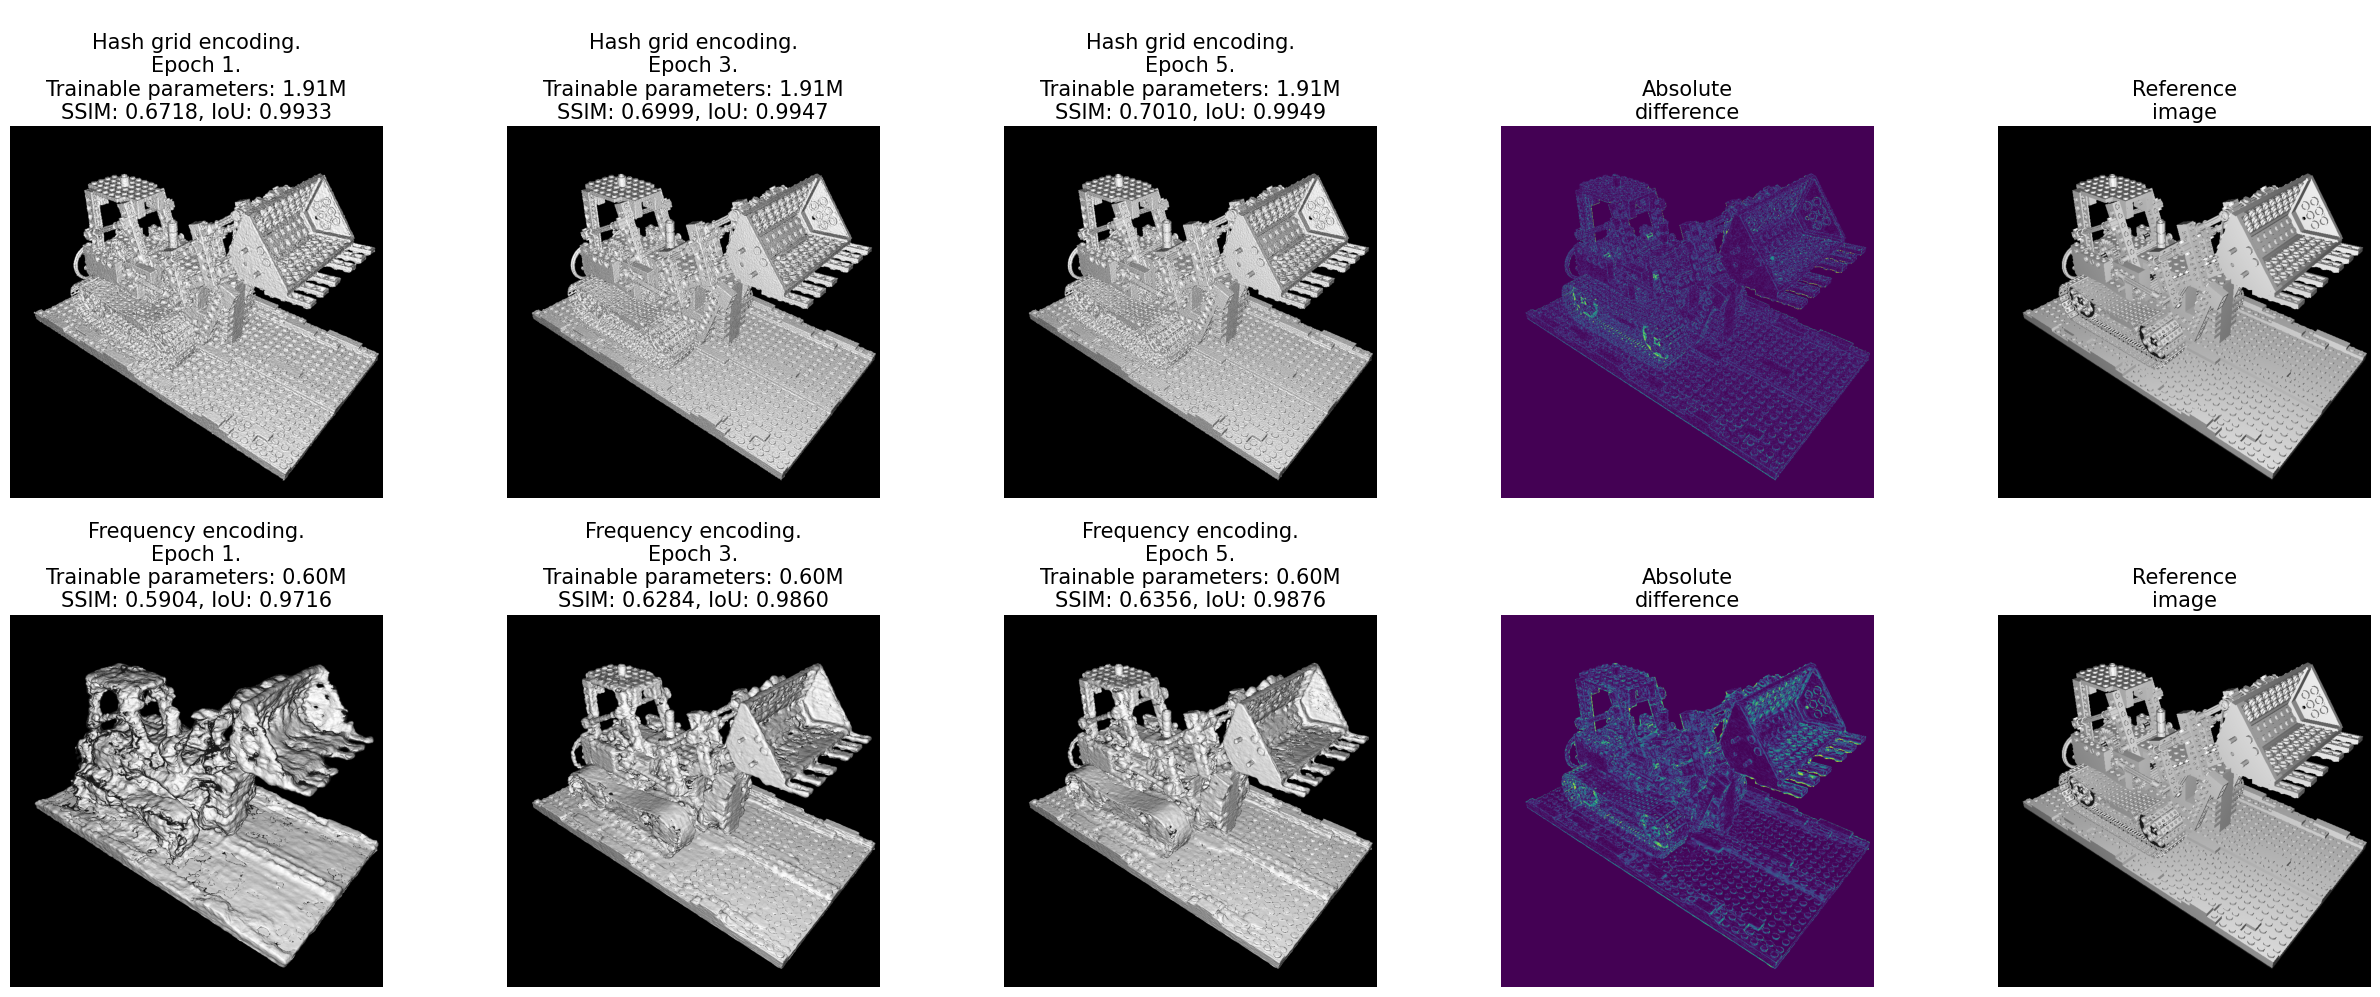

In [19]:
n_rows = len(results)
n_cols = (n_epochs + 1) // 2 + 2

fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))

points, norm = trainer.ref_render()
ref_image = calculate_lambert(norm, points, light_source, intensity=light_intensity)

for i, (name, images) in enumerate(results.items()):
    # show rendered images
    for j, image in enumerate(images):
        if j % 2 == 0:
            ssim_val = ssim(image, ref_image, data_range=np.max(ref_image) - np.min(ref_image))
            iou_val = iou(image, ref_image)
            ax[i, j // 2].imshow(image, cmap='gray', vmin=0, vmax=1)
            ax[i, j // 2].axis("off")
            ax[i, j // 2].set_title(f"\n{name} encoding.\nEpoch {j+1}.\nTrainable parameters: {params_count[name] / 1e6:.2f}M\nSSIM: {ssim_val:.4f}, IoU: {iou_val:.4f}", fontsize=15)

    # show absolute difference
    diff_image = np.abs(image - ref_image)
    ax[i, n_cols - 2].imshow(diff_image, vmin=0, vmax=1)
    ax[i, n_cols - 2].axis("off")
    ax[i, n_cols - 2].set_title(f"Absolute\ndifference", fontsize=15)
    
    # show reference
    ax[i, n_cols - 1].imshow(ref_image, cmap='gray', vmin=0, vmax=1)
    ax[i, n_cols - 1].axis("off")
    ax[i, n_cols - 1].set_title(f"Reference\nimage", fontsize=15)
    
plt.tight_layout()

plt.savefig("fig.png")
plt.show()

As expected, the network with a hash grid wins over frequency encoding in almost all parameters: quality, speed, convergence. 

One of the notable issues is noticeable noise on the surface, which the authors attribute to hash collisions.

**References:**

1. Thomas Müller, Alex Evans, Christoph Schied, and Alexander Keller. 2022. Instant neural graphics primitives with a multiresolution hash encoding. ACM Trans. Graph. 41, 4, Article 102 (July 2022), 15 pages. https://doi.org/10.1145/3528223.3530127
2. Hash grid for primary rays: https://github.com/Alehandreus/neural-intersection